In [5]:
!pip install openpyxl
!pip install xlsxwriter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 1.6 MB/s eta 0:00:00


In [6]:
import pandas as pd
import numpy as np
import openpyxl
import xlsxwriter

import statsmodels.api as sm
from scipy.stats import ttest_rel, false_discovery_control
from scipy.stats import shapiro, anderson, wilcoxon, chi2_contingency, contingency, pointbiserialr

from collections import namedtuple
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import matplotlib.font_manager as fm

In [7]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab_Notebooks/oai/TKR_twin'

Mounted at /content/drive
/content/drive/MyDrive/Colab_Notebooks/oai/TKR_twin


In [8]:
# Set the random seed for reproducibility
np.random.seed(42)

In [9]:
!unzip "/content/drive/MyDrive/Colab_Notebooks/oai/control_used_for_embedding/Noto_Serif.zip"


Archive:  /content/drive/MyDrive/Colab_Notebooks/oai/control_used_for_embedding/Noto_Serif.zip
replace OFL.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
  inflating: NotoSerif-Regular.ttf   
replace NotoSerif-Italic.ttf? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace NotoSerif-Bold.ttf? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace NotoSerif-BoldItalic.ttf? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [10]:
!mv NotoSerif-Regular.ttf /usr/share/fonts/truetype/

**Merge Dataframes**

In [11]:
def load_and_merge_data(full_data_path, match_data_path, merge_key, selected_columns):
    full_df = pd.read_csv(full_data_path)
    match_df = pd.read_csv(match_data_path, usecols=selected_columns)
    merged_df = pd.merge(match_df, full_df, on=merge_key, how='left')
    return merged_df

selected_columns = ['distance','id']
oa_inc_matched_df = load_and_merge_data(
    'publish_dataframes/oa_inc_multiple_imputation_filled.csv',
    'publish_dataframes/rand_state_oa_inc_matchit_TSNE_EuclideanDist_Replacement_df.csv',
    'id',
    selected_columns
)
# oa_inc_matched_df

tkr_matched_df = load_and_merge_data(
    'publish_dataframes/tkr_multiple_imputation_filled.csv',
    'publish_dataframes/rand_state_tkr_matchit_TSNE_EuclideanDist_Replacement_df.csv',
    'id',
    selected_columns
)

# oa_inc_matched_df.to_csv('publish_dataframes/rand_state_oa_inc_matched_IDs_PC_modes.csv', index=False)
# tkr_matched_df.to_csv('publish_dataframes/rand_state_tkr_matched_IDs_PC_modes.csv', index=False)

**Dataframes from Before and After Match**

In [12]:
# Before Matching

# OA Incidence
oa_inc_before_match = pd.read_csv('publish_dataframes/oa_inc_multiple_imputation_filled.csv')
# numerical_cols = oa_inc_before_match.iloc[:,16:-110].columns.tolist()
# categorical_cols = oa_inc_before_match.iloc[:,7:16].columns.tolist()

# TKR
tkr_before_match = pd.read_csv('publish_dataframes/tkr_multiple_imputation_filled.csv')
# numerical_cols = tkr_before_match.iloc[:,16:-110].columns.tolist()
# categorical_cols = tkr_before_match.iloc[:,7:16].columns.tolist()

In [ ]:
# After Matching

# OA Incidence
# numerical_cols = oa_inc_matched_df.iloc[:,17:-110].columns.tolist()
# categorical_cols = oa_inc_matched_df.iloc[:,8:17].columns.tolist()

# TKR
# numerical_cols = tkr_matched_df.iloc[:,17:-110].columns.tolist()
# categorical_cols = tkr_matched_df.iloc[:,8:17].columns.tolist()

**Love Plots for Comparing Matching on Numerical Continuous Covariates**

In [29]:

# Standardized Mean Difference Function
def standardized_mean_difference(df1, df2, variable):
    mean1, mean2 = df1[variable].mean(), df2[variable].mean()
    pooled_std = np.sqrt((df1[variable].std()**2 + df2[variable].std()**2) / 2)
    return (mean1 - mean2) / pooled_std

def create_love_plot(df_before, df_after, target_column, covariates, path_to_font, title, save_path=None, before_color='#3f6263', after_color='#8f82bd'):

    # Font properties
    fontprop = fm.FontProperties(fname=path_to_font, size=15)

    # Separate into control and treatment groups
    df_before_control = df_before[df_before[target_column] == 0]
    df_before_treatment = df_before[df_before[target_column] == 1]
    df_after_control = df_after[df_after[target_column] == 0]
    df_after_treatment = df_after[df_after[target_column] == 1]

    # Calculate SMD for each covariate
    smd_before = [standardized_mean_difference(df_before_control, df_before_treatment, var) for var in covariates]
    smd_after = [standardized_mean_difference(df_after_control, df_after_treatment, var) for var in covariates]

    # Creating the plot
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
    ax.hlines(y=covariates, xmin=smd_before, xmax=smd_after, color='grey', alpha=0.7)
    ax.scatter(smd_before, covariates, color=before_color, alpha=1, label='Before Matching',  s=100)
    ax.scatter(smd_after, covariates, color=after_color, alpha=1, label='After Matching',  s=100)
    ax.axvline(x=0, color='black', linestyle='--')

    # Plot settings
    plt.xlabel('Standardized Mean Difference (SMD)', fontproperties=fontprop)
    plt.title(title, fontproperties=fontprop, fontsize=20)
    plt.legend()
    plt.setp(ax.get_legend().get_texts(), fontproperties=fontprop) # legend text
    plt.setp(ax.get_legend().get_title(), fontproperties=fontprop)

    # Tick labels font settings
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(fontprop)

    # Save or show the plot
    if save_path:
        plt.savefig(save_path, format='svg', bbox_inches='tight')
    else:
        plt.show()


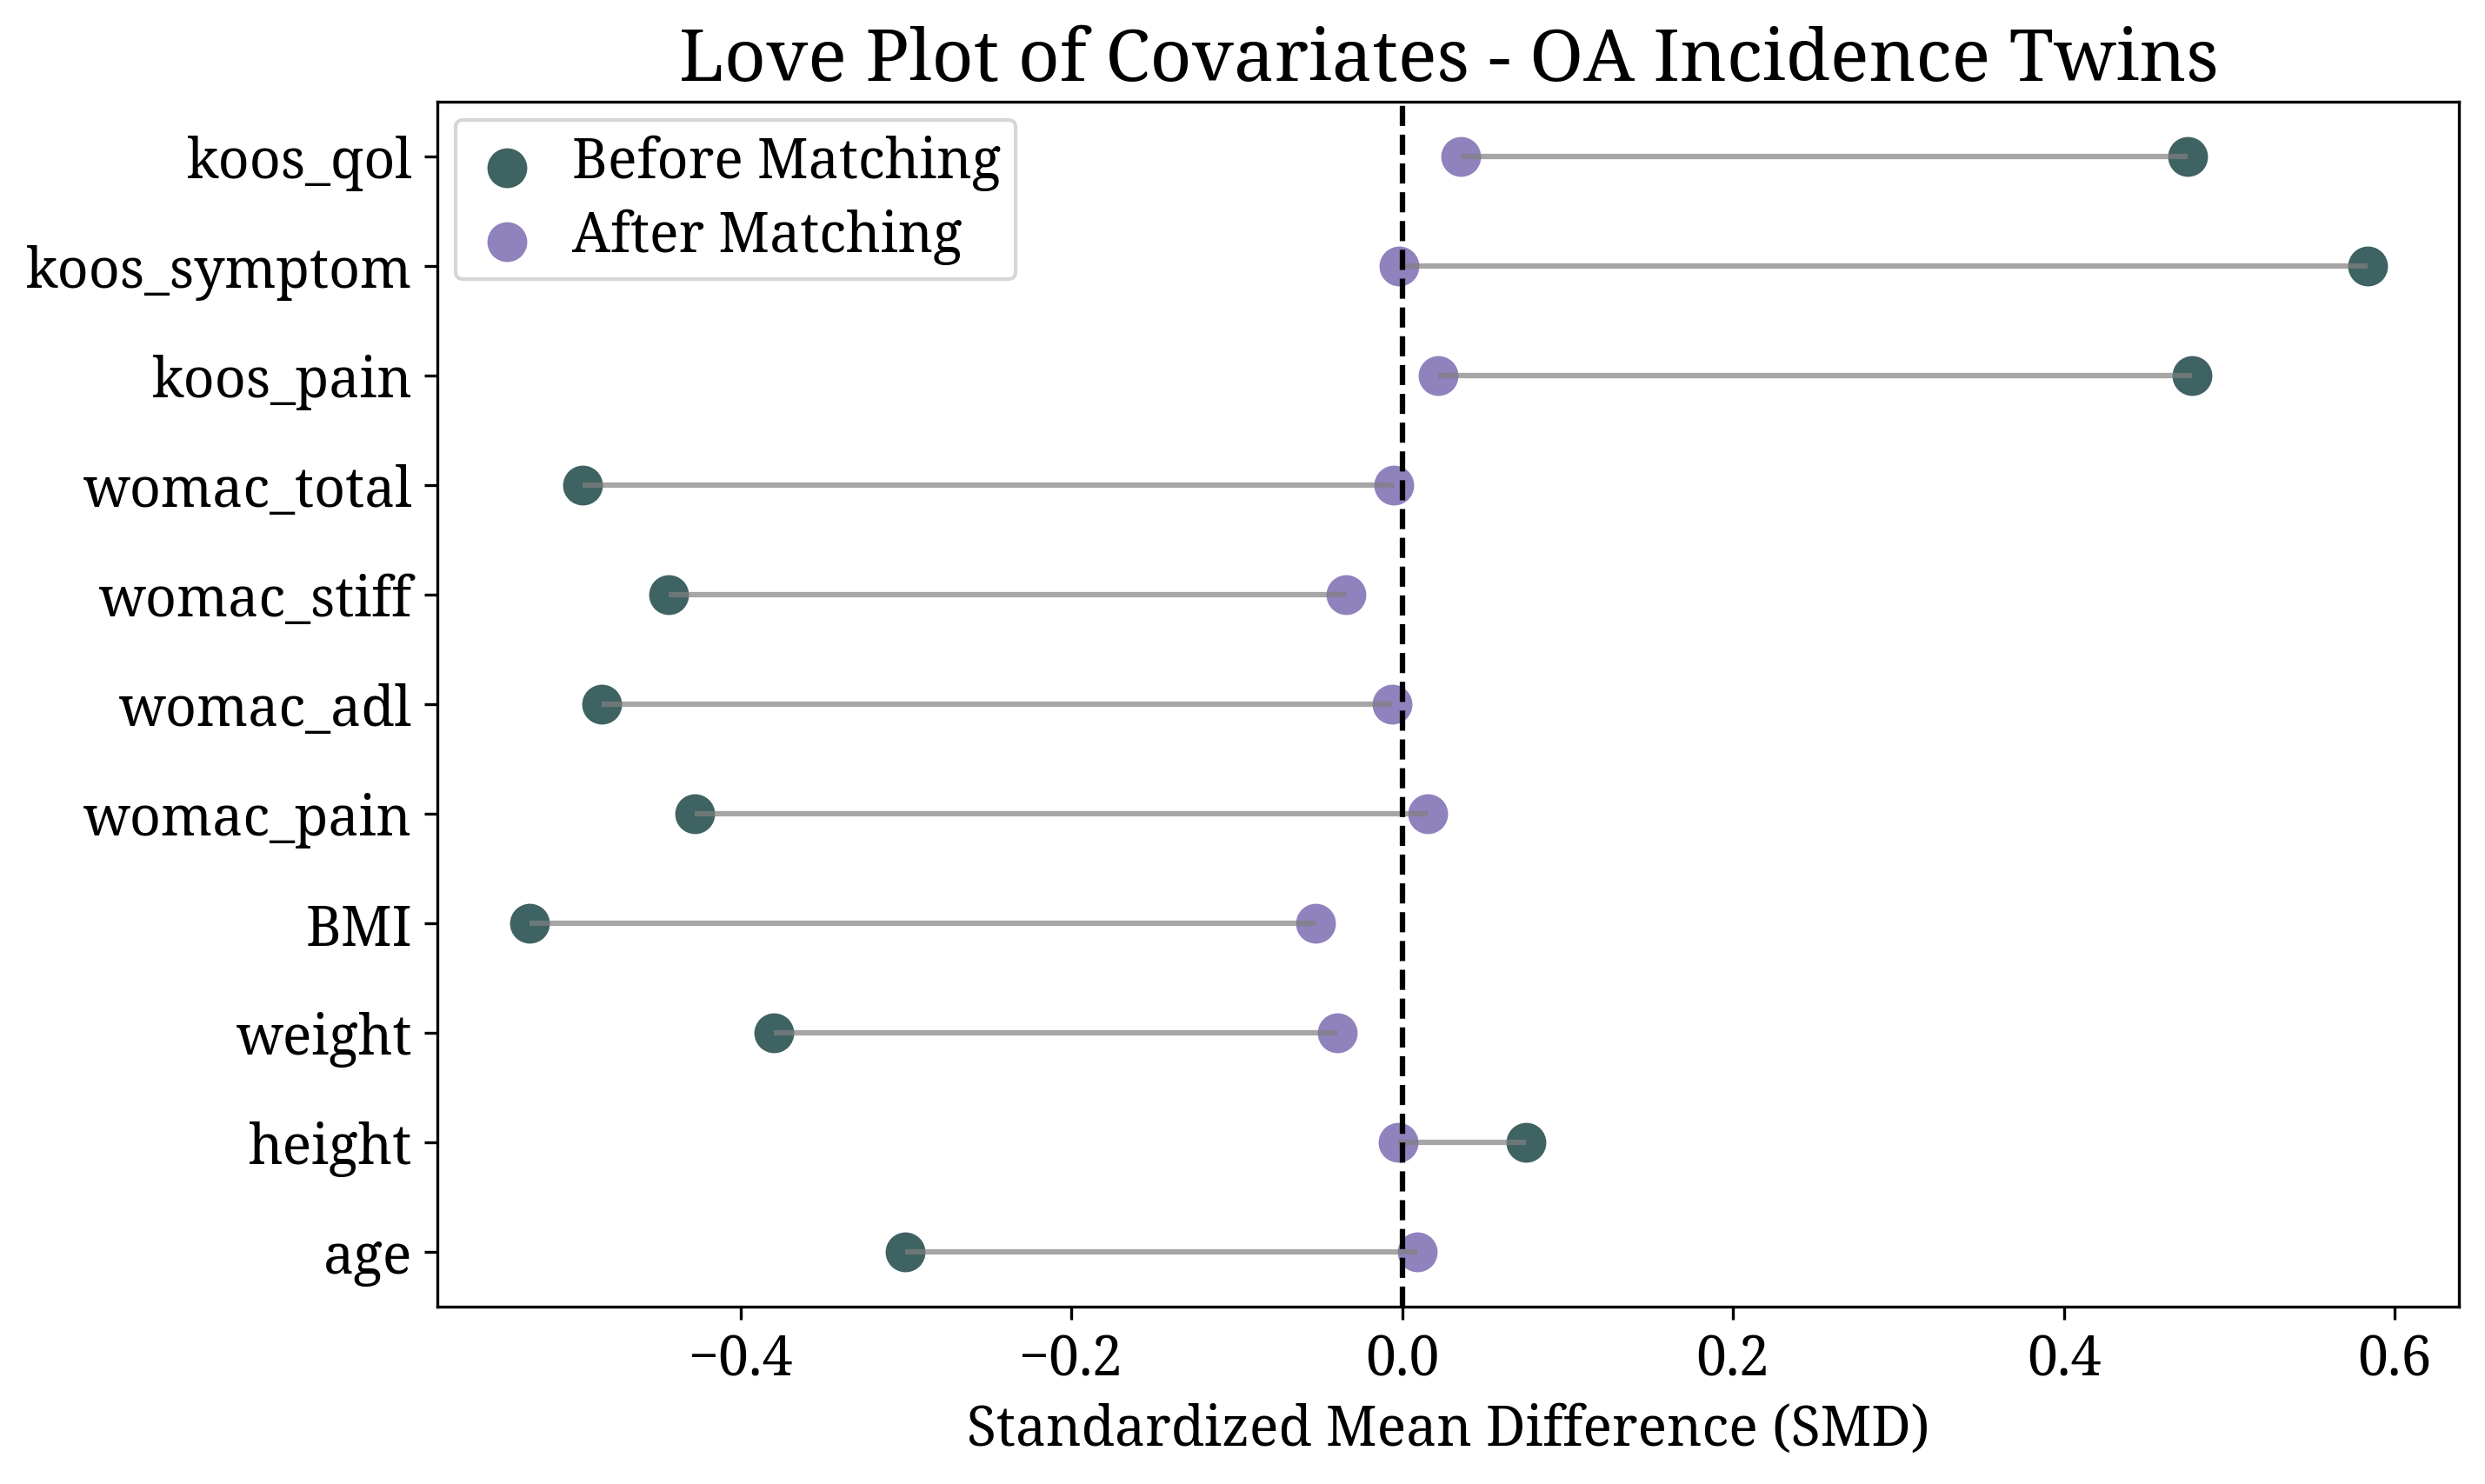

In [30]:
# create_love_plot(df_before, df_after, 'oa_prog', '/path/to/font.ttf', 'Love Plot Title')

df_before = oa_inc_before_match
df_after = oa_inc_matched_df
selected_covariates = df_before.iloc[:,16:-110].columns.to_list()
path_to_font = '/usr/share/fonts/truetype/NotoSerif-Regular.ttf'
title = 'Love Plot of Covariates - OA Incidence Twins'

# save_path = '/content/drive/MyDrive/Colab_Notebooks/oai/TKR_twin/publish_dataframes/TSNE_with_random_state/figures/OA_Inc_numerical_Love_plot.svg'

create_love_plot(df_before, df_after, 'oa_prog', selected_covariates, path_to_font, title)


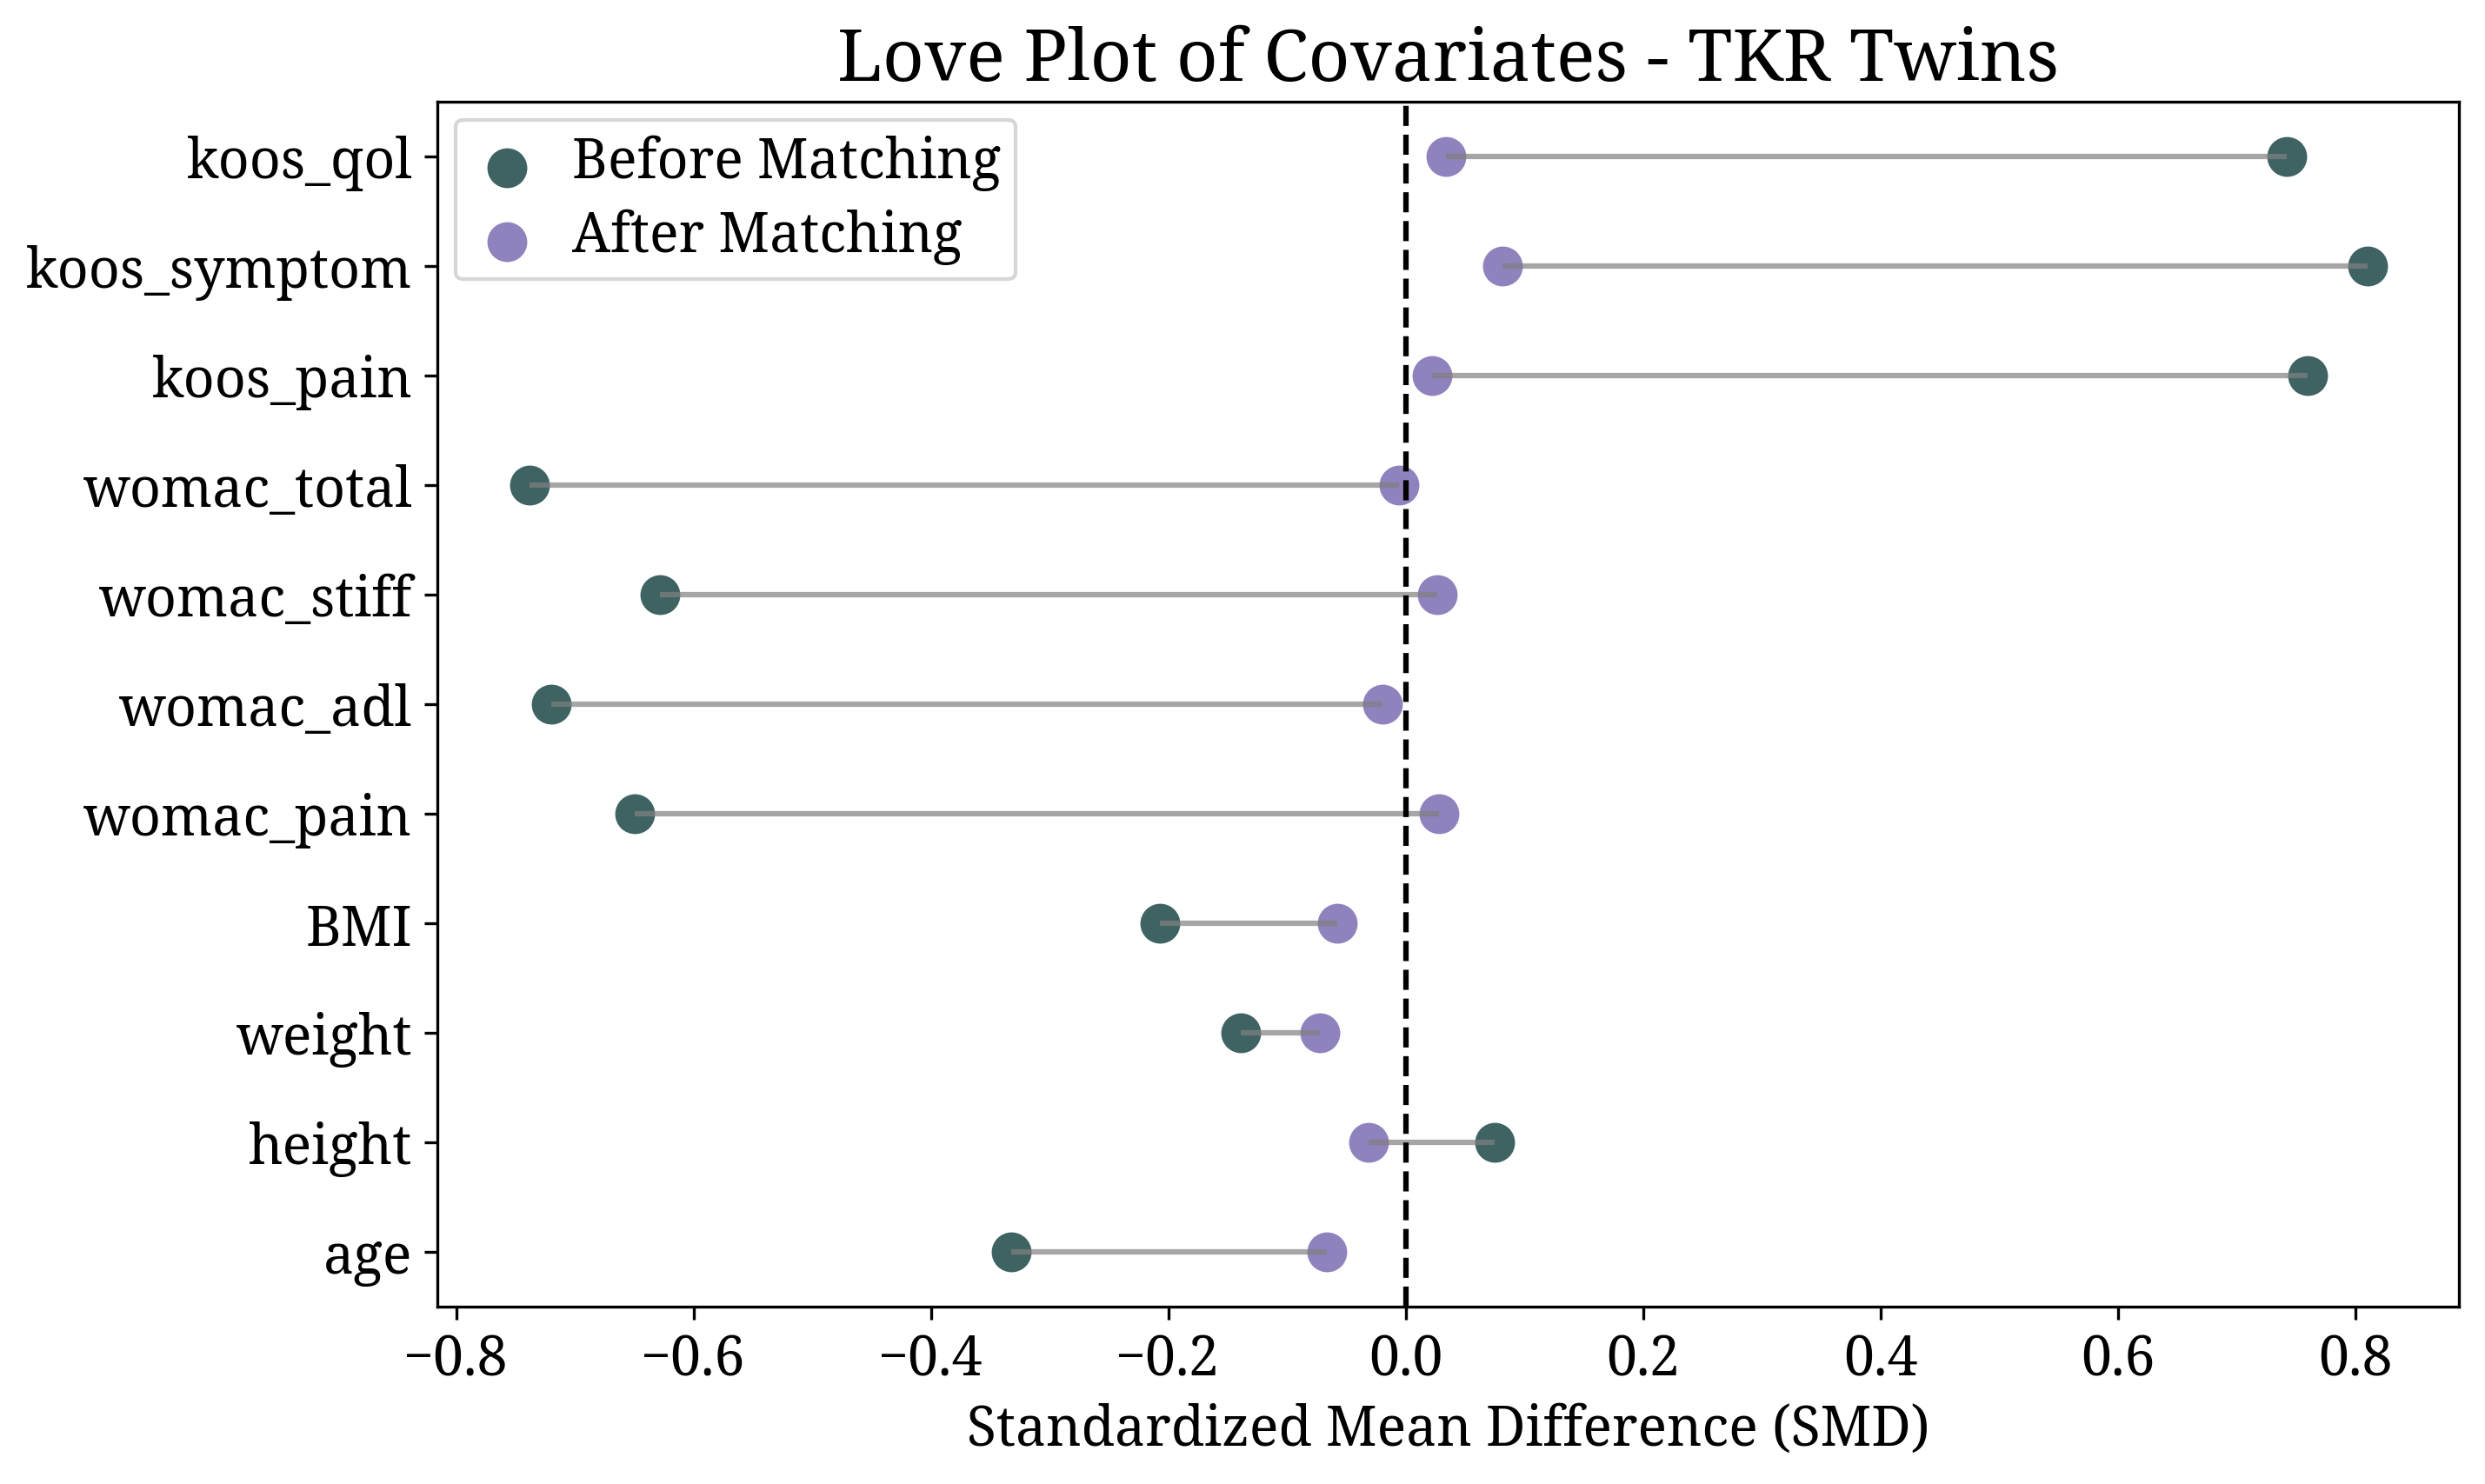

In [31]:
df_before = tkr_before_match
df_after = tkr_matched_df

selected_covariates = df_before.iloc[:,16:-110].columns.to_list()
path_to_font = '/usr/share/fonts/truetype/NotoSerif-Regular.ttf'
title = 'Love Plot of Covariates - TKR Twins'

# save_path = '/content/drive/MyDrive/Colab_Notebooks/oai/TKR_twin/publish_dataframes/TSNE_with_random_state/figures/TKR_numerical_Love_plot.svg'

create_love_plot(df_before, df_after, 'tkr', selected_covariates, path_to_font, title)


**Bar Plots for Comparing Matching on Categorical Covariates**

In [40]:

def create_categorical_bar_plot(df_before, df_after, target_column, covariates, path_to_font, title, treatment_label='Treatment', save_path=None, control_color='#3f6263', treatment_color='#8f82bd'):
    # Font properties
    fontprop = fm.FontProperties(fname=path_to_font, size=15)

    # Ensure covariates are in the correct format (e.g., as integers)
    df_before[covariates] = df_before[covariates].applymap(lambda x: float(x)).astype(int)
    df_after[covariates] = df_after[covariates].applymap(lambda x: float(x)).astype(int)

    # Separate data into control and treatment groups
    df_before_control = df_before[df_before[target_column] == 0][covariates]
    df_before_treatment = df_before[df_before[target_column] == 1][covariates]
    df_after_control = df_after[df_after[target_column] == 0][covariates]
    df_after_treatment = df_after[df_after[target_column] == 1][covariates]

    # Combine and melt the dataframes
    combined_df = pd.concat([
        df_before_control.assign(Group='Control', Time='Before'),
        df_before_treatment.assign(Group=treatment_label, Time='Before'),
        df_after_control.assign(Group='Control', Time='After'),
        df_after_treatment.assign(Group=treatment_label, Time='After')
    ])

    # Melt to long format
    melted_df = combined_df.melt(id_vars=['Group', 'Time'], var_name='Variable', value_name='Value')

    # Count the frequency for each category
    count_df = melted_df.groupby(['Variable', 'Value', 'Group', 'Time']).size().reset_index(name='Count')

    # Color palette
    my_palette = [control_color, treatment_color]

    # Get the list of variables
    variables = count_df['Variable'].unique()

    # Set up the matplotlib figure with two columns
    sns.set_context("talk")
    sns.set_style("whitegrid")

    n_vars = len(variables)
    fig, axes = plt.subplots(n_vars, 2, figsize=(15, 5 * n_vars))  # Adjust figsize as needed

    # Create a bar plot for each variable in each time period
    for i, variable in enumerate(variables):
        for j, time in enumerate(['Before', 'After']):
            sns.barplot(x='Value', y='Count', hue='Group',
                        data=count_df[(count_df['Variable'] == variable) & (count_df['Time'] == time)],
                        ax=axes[i, j], palette=my_palette, edgecolor="black", linewidth=2)
            axes[i, j].set_title(f'{variable} - {time} Matching', fontproperties=fontprop, fontsize=18)
            axes[i, j].set_xlabel('Category', fontproperties=fontprop, fontsize=14)
            axes[i, j].set_ylabel('Count', fontproperties=fontprop, fontsize=14)
            axes[i, j].legend(title='Group')

            # Set legend and tick labels font properties
            plt.setp(axes[i, j].get_legend().get_texts(), fontproperties=fontprop)
            plt.setp(axes[i, j].get_legend().get_title(), fontproperties=fontprop)
            for label in axes[i, j].get_xticklabels() + axes[i, j].get_yticklabels():
                label.set_fontproperties(fontprop)

    plt.suptitle(title, y=1.0, fontproperties=fontprop, fontsize=25)
    plt.tight_layout()

    # Save or show the plot
    if save_path:
        plt.savefig(save_path, format='svg', bbox_inches='tight')
    else:
        plt.show()



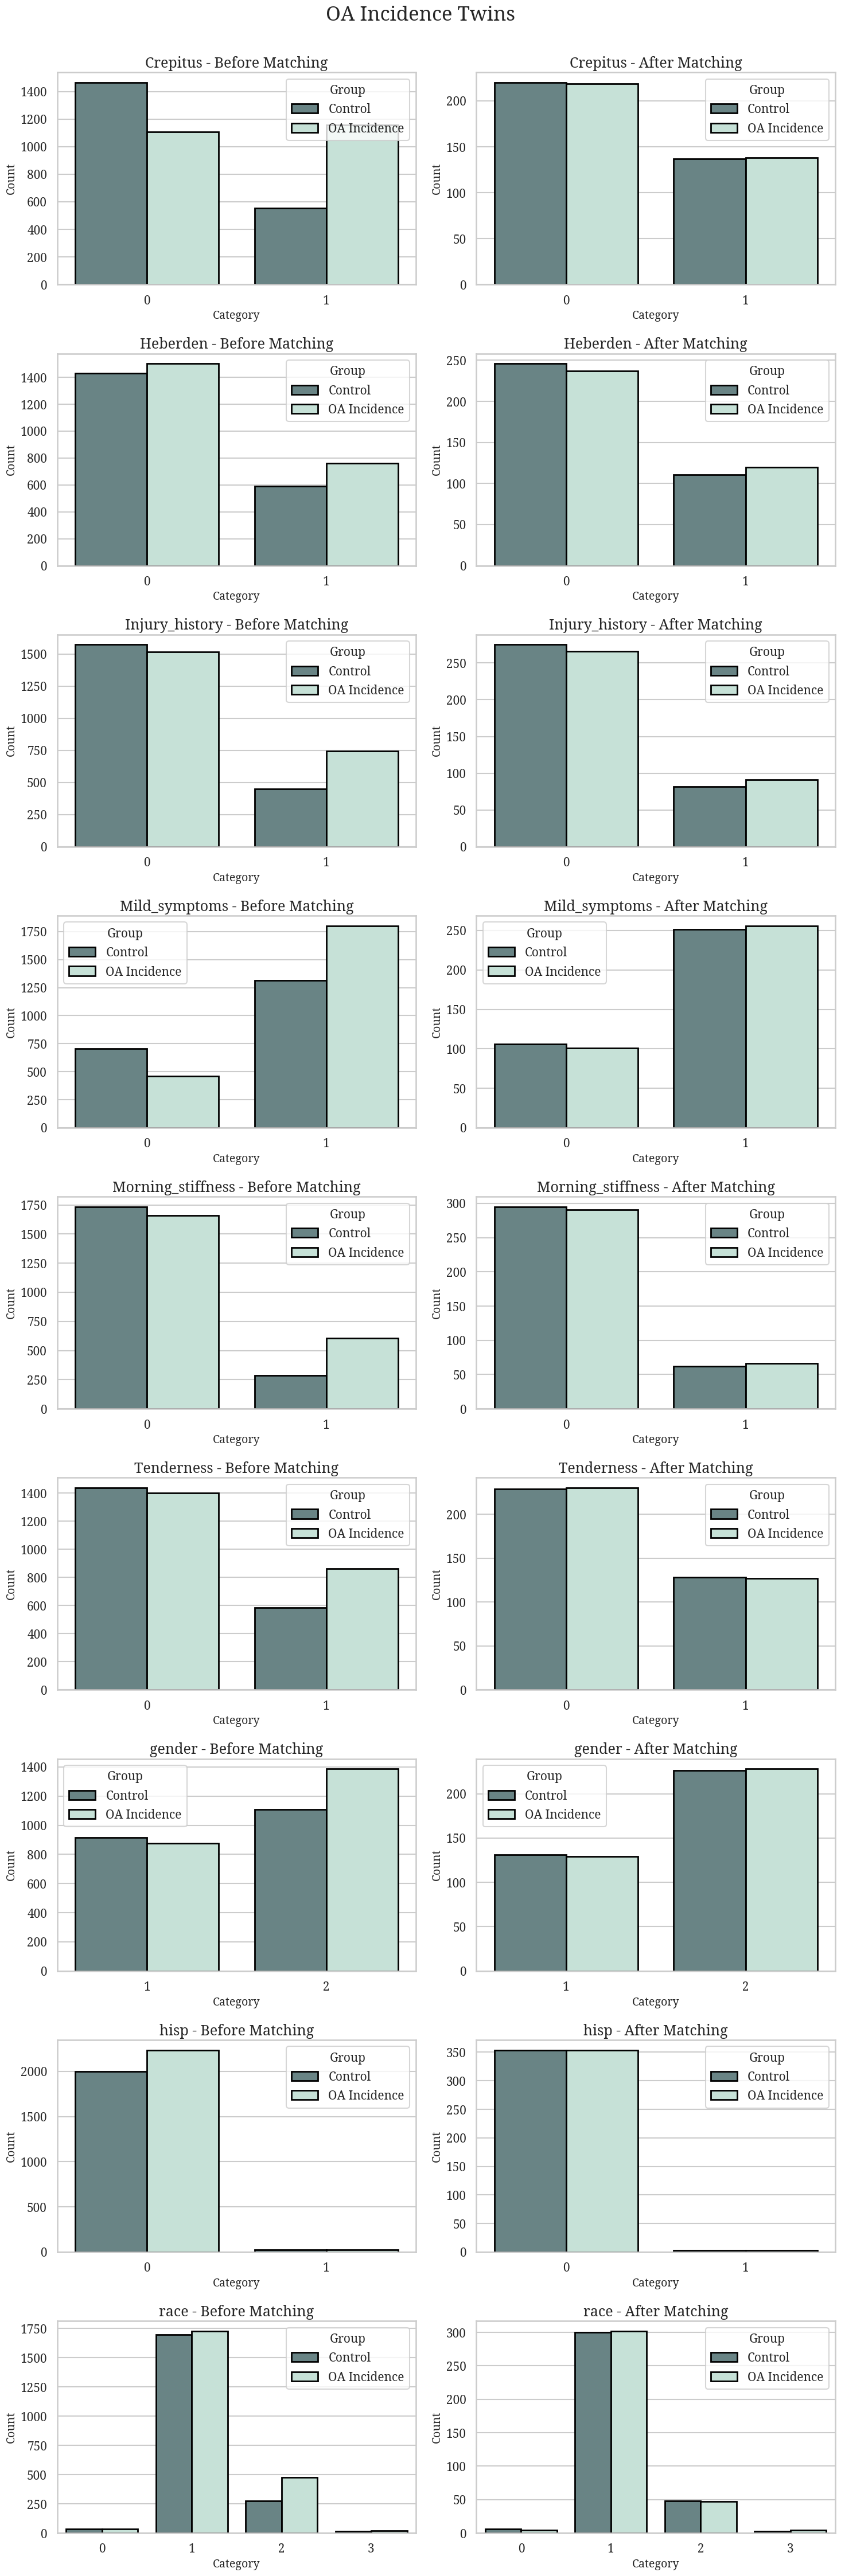

In [41]:
columns = oa_inc_before_match.iloc[:,7:16].columns.tolist()

cmap = sns.cubehelix_palette(start=.5, rot=-.5)
treatment_color = cmap[0]
control_color = '#64888A'

# save_path = '/content/drive/MyDrive/Colab_Notebooks/oai/TKR_twin/publish_dataframes/TSNE_with_random_state/figures/OA_Inc_categorical_bar_plot.svg'

# Example usage:
create_categorical_bar_plot(df_before=oa_inc_before_match,
                            df_after=oa_inc_matched_df,
                            target_column='oa_prog',
                            covariates=columns,  # replace with actual column names
                            path_to_font='/usr/share/fonts/truetype/NotoSerif-Regular.ttf',
                            title='OA Incidence Twins',
                            treatment_label = 'OA Incidence',
                            control_color=control_color, treatment_color=treatment_color)



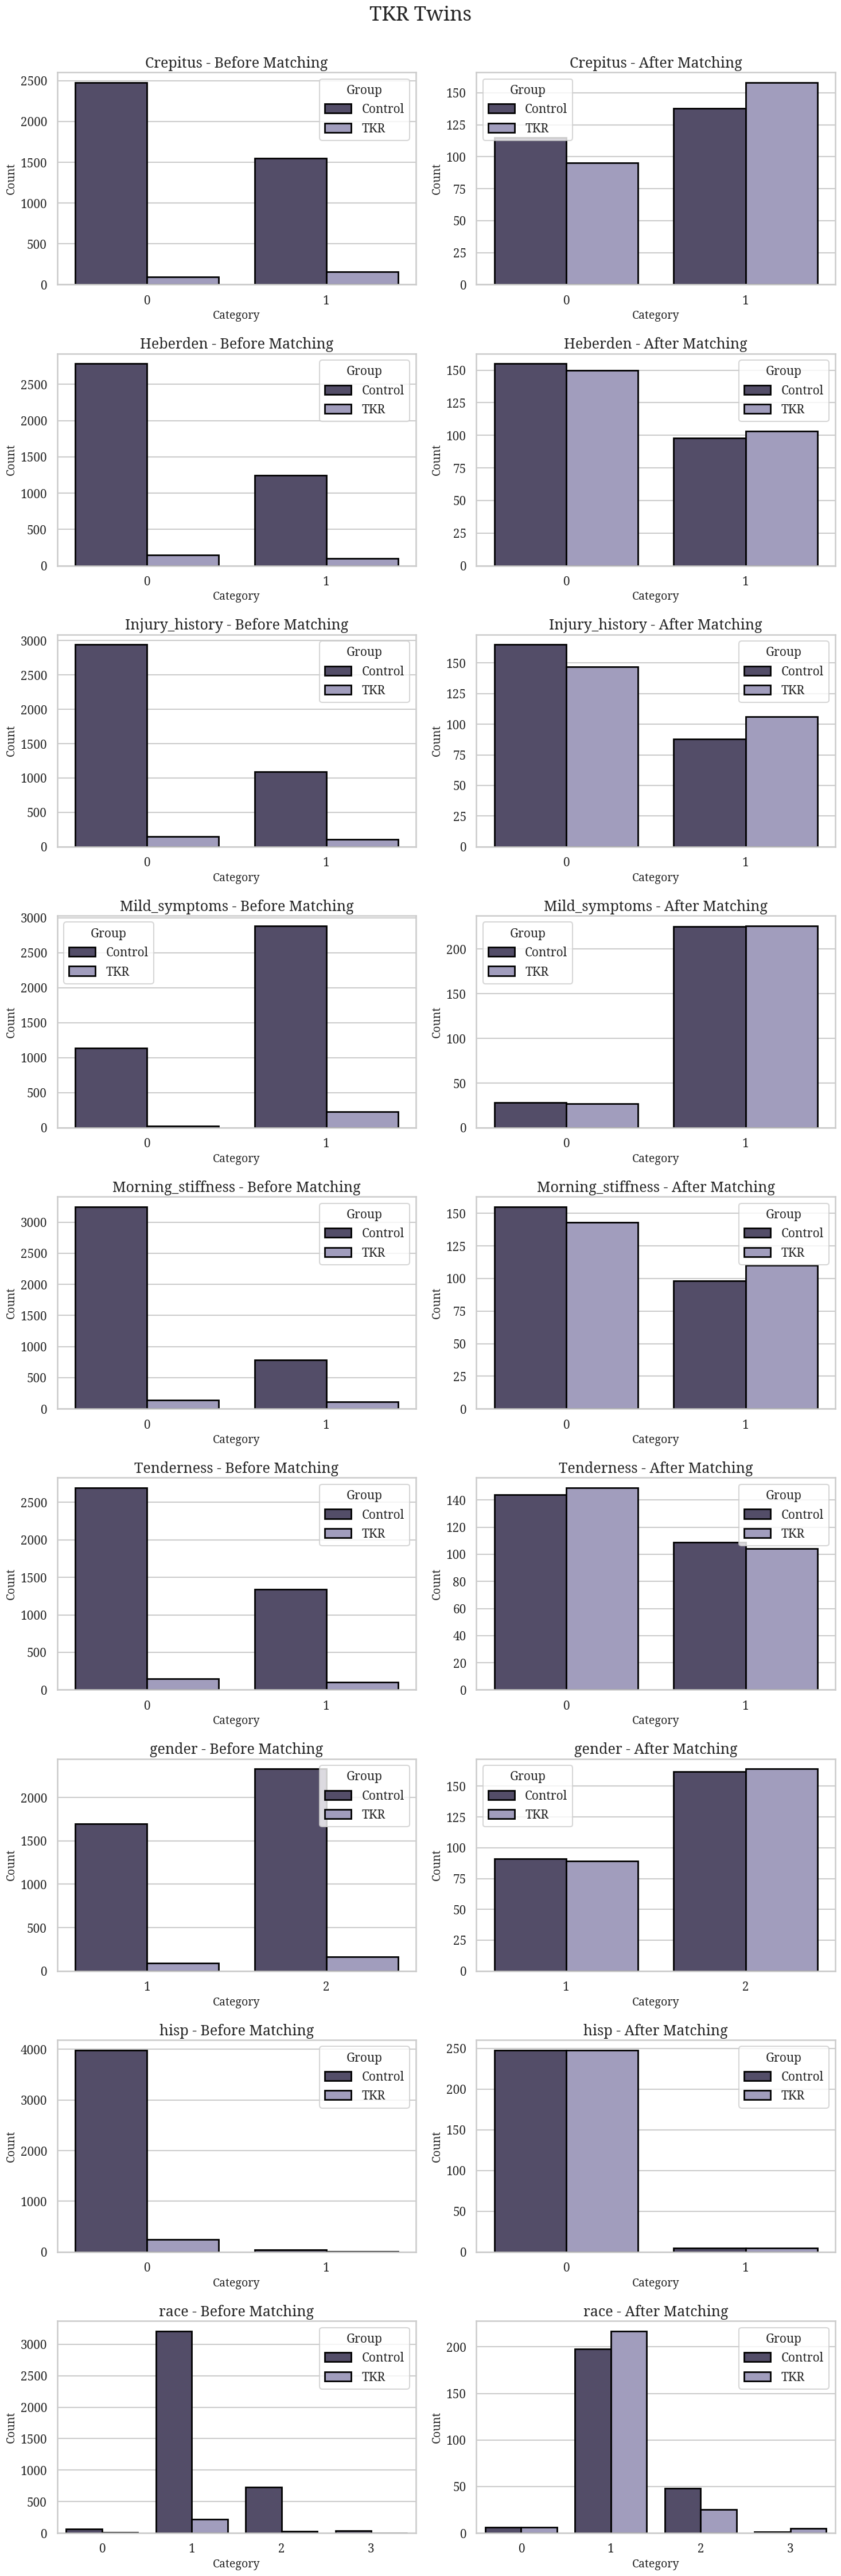

In [42]:
columns = tkr_before_match.iloc[:,7:16].columns.tolist()

treatment_color = '#9D98C2'
control_color = '#50486D'  # Darker color for control

# save_path = '/content/drive/MyDrive/Colab_Notebooks/oai/TKR_twin/publish_dataframes/TSNE_with_random_state/figures/TKR_categorical_bar_plot.svg'

# Example usage:
create_categorical_bar_plot(df_before=tkr_before_match,
                            df_after=tkr_matched_df,
                            target_column='tkr',
                            covariates=columns,  # replace with actual column names
                            path_to_font='/usr/share/fonts/truetype/NotoSerif-Regular.ttf',
                            title='TKR Twins',
                            treatment_label='TKR',
                            control_color=control_color, treatment_color=treatment_color)
